In [1]:
import sklearn as sk
import scipy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


Loading file containing training and validation data sets as well as another file containing test data set

In [2]:
filePath = "spam_train.txt"
file=open(filePath)
emailList = file.read().splitlines()  
filePath2 = "spam_test.txt"
file2=open(filePath2)
testList = file2.read().splitlines()

Splitting data into training set and validation set
If the Validation set was not created,It would not be possible to adjust the parameters like no of data passes and Number of words to be removed from the vocabulary so as to adjust the weight vector to yeild the best result since you are not allowed to look at the test set.

In [3]:
train_data=emailList[0:4000]
validation_data=emailList[4000:]

Extracting out spam values from the above data for train  ,validation set as well as test set

In [4]:
new_email_train=[]
spam_value_train=[]
for email in train_data:
    spam_value_train.append((int)(email[0]))
    new_email_train.append(email[2:])
new_email_validate=[]
spam_value_validate=[]
for email in validation_data:
    spam_value_validate.append((int)(email[0]))
    new_email_validate.append(email[2:])
    
for i in range(0,len(spam_value_train)):
    if(spam_value_train[i]==0):
        spam_value_train[i]=-1

for i in range(0,len(spam_value_validate)):
    if(spam_value_validate[i]==0):
        spam_value_validate[i]=-1

new_email_test=[]
spam_value_test=[]
for email in testList:
    spam_value_test.append((int)(email[0]))
    new_email_test.append(email[2:])



Calculating the frequency of each word in the vocabulary(In how many emails they appeared)

In [5]:
count_vect = CountVectorizer()
email_train_counts = count_vect.fit_transform(new_email_train)
email_train_counts_validate = count_vect.transform(new_email_validate)
email_train_counts_test = count_vect.transform(new_email_test)

freq={}
cx = scipy.sparse.coo_matrix(email_train_counts)
cxv = scipy.sparse.coo_matrix(email_train_counts_validate)
cxt = scipy.sparse.coo_matrix(email_train_counts_test)

for i,j in zip(cx.row, cx.col):
    if(j in freq.keys()):
        freq[j] = freq[j]+1
    else:
        freq[j]=1




Removing words whose freq is less than 30 from the vocab(Initially 30 was used but 60 yeilded a better error performance)

In [6]:
words=[]
for key in count_vect.vocabulary_:
    if(freq[count_vect.vocabulary_[key]]<30):
        words.append(key)
for word in words:
    count_vect.vocabulary_.pop(word)

Storing the words and the corresponding unique id in a dictionary

In [7]:
words_to_number_map={}
i=0
for key in count_vect.vocabulary_:
    words_to_number_map[count_vect.vocabulary_[key]] = i
    i=i+1

Forming a feature vector for training data and validation data

In [8]:
feature_vector = np.zeros((4000,len(words_to_number_map)),dtype=int)
for i,j in zip(cx.row, cx.col):
    if(j in words_to_number_map.keys()):
        feature_vector[i][words_to_number_map[j]]=1
feature_vector_validate = np.zeros((1000,len(words_to_number_map)),dtype=int)
for i,j in zip(cxv.row, cxv.col):
    if(j in words_to_number_map.keys()):
        feature_vector_validate[i][words_to_number_map[j]]=1        


Implementing the Perceptron Train Method returning w,iterations,count_wrong

In [9]:
def perceptron_train(feature_vector,spam_value_train):
    w = np.zeros(len(feature_vector[1]))
    count=1
    iterations=0
    count_wrong=0
    while(count!=0):
        count=0
        for i in range(0,len(feature_vector)):
            x = feature_vector[i]
            y = spam_value_train[i]
            product = np.dot(w,x)
            if(y*product<0 or (y*product==0 and y==-1)):
                w = w + y*x
                count_wrong=count_wrong+1
                count=count+1
        iterations=iterations+1
    return w,iterations,count_wrong
w,iterations,incorrect_no = perceptron_train(feature_vector,spam_value_train)


Implementing the Perceptron_test method

In [10]:
def perceptron_test(w,feature_vector_validate,spam_value_validate):
    sum=0
    for i in range(0,len(feature_vector_validate)):
        if(spam_value_validate[i]*np.dot(w,feature_vector_validate[i])<0 or(np.dot(w,feature_vector_validate[i])==0 and spam_value_validate[i]==-1) ):
            sum=sum+1
    return sum/len(feature_vector_validate)
errors = perceptron_test(w,feature_vector_validate,spam_value_validate)

Next block contains the Value of The errors made before converging and the validation error

In [11]:
print("The number of errors made to reach convergence: " + str(incorrect_no) + " The validation error = "+str(errors))


The number of errors made to reach convergence: 443 The validation error = 0.023


Finding out the 15 most negative weights

In [12]:
word_weights_map={}
i=0
for weight in w:
    word_id = list(words_to_number_map.keys())[list(words_to_number_map.values()).index(i)]
    word = list(count_vect.vocabulary_.keys())[list(count_vect.vocabulary_.values()).index(word_id)]
    if(weight in word_weights_map.keys()):
        new_list=word_weights_map[weight]
        new_list.append(word)
        word_weights_map[weight] = new_list
    else:
        word_list=[]
        word_list.append(word)
        word_weights_map[weight] = word_list
    i=i+1
count = 15
negative_list=[]
for key in sorted(word_weights_map.keys()):
    wlist = word_weights_map[key]
    for word in wlist:
        negative_list.append(word)
        count=count-1
        if(count <= 0):
            break
    if(count <= 0):
            break
negative_list

['wrote',
 'prefer',
 'still',
 'server',
 'inc',
 'rpm',
 'reserv',
 'url',
 'technolog',
 'execut',
 're',
 'said',
 'standard',
 'microsoft',
 'post']

Finding out 15 Most positive words

In [13]:
positive_list=[]
count=15
for key in sorted(word_weights_map.keys(),reverse=True):
    wlist = word_weights_map[key]
    for word in wlist:
        positive_list.append(word)
        count=count-1
        if(count <= 0):
            break
    if(count <= 0):
            break
positive_list

['remov',
 'click',
 'sight',
 'our',
 'market',
 'guarante',
 'deathtospamdeathtospamdeathtospam',
 'price',
 'present',
 'hour',
 'will',
 'process',
 'pleas',
 'size',
 'ever']

In [14]:
def average_perceptron_train(feature_vector,spam_value_train):
    w = np.zeros(len(feature_vector[1]))
    cnt=1
    itera=0
    avg_w=np.zeros(len(feature_vector[1]))
    while(cnt!=0):
        cnt=0
        for i in range(0,len(feature_vector)):
            x = feature_vector[i]
            y = spam_value_train[i]
            product = np.dot(w,x)
            if(y*product<0 or (y*product==0 and y==-1)):
                w = w + y*x
                cnt=cnt+1
            avg_w=avg_w+w
            itera=itera+1
    return avg_w/itera


Overloading functions with iterations as a param

In [15]:
def perceptron_train(feature_vector,spam_value_train,Iterations):
    w = np.zeros(len(feature_vector[1]))
    iterations=0
    while(iterations <Iterations ):
        for i in range(0,len(feature_vector)):
            x = feature_vector[i]
            y = spam_value_train[i]
            product = np.dot(w,x)
            if(y*product<0 or (y*product==0 and y==-1)):
                w = w + y*x
        iterations=iterations+1
    return w
def average_perceptron_train(feature_vector,spam_value_train,Iterations):
    w = np.zeros(len(feature_vector[1]))
    itera=0
    avg_w=np.zeros(len(feature_vector[1]))
    while(itera <Iterations):
        for i in range(0,len(feature_vector)):
            x = feature_vector[i]
            y = spam_value_train[i]
            product = np.dot(w,x)
            if(y*product<0 or (y*product==0 and y==-1)):
                w = w + y*x
        itera=itera+1
        avg_w=avg_w+w
    return avg_w/itera

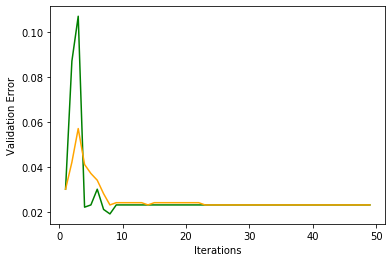

In [16]:
e1=[]
e2=[]
iter=[]
for Iterations in range(1,50):
    w1 = perceptron_train(feature_vector,spam_value_train,Iterations)
    w2 = average_perceptron_train(feature_vector,spam_value_train,Iterations)
    e1.append(perceptron_test(w1,feature_vector_validate,spam_value_validate))
    e2.append(perceptron_test(w2,feature_vector_validate,spam_value_validate))
    iter.append(Iterations)
    
plt.plot(iter, e1, color='g')
plt.plot(iter, e2, color='orange')
plt.xlabel('Iterations')
plt.ylabel('Validation Error')
plt.show()

    
    

The best validation Error for X=30 and 50 iterations was (perceptron)

In [17]:
e1[len(e1)-1]

0.023

The best validation Error for X=30 and 50 iterations was (Average perceptron)

In [19]:
e2[len(e2)-1]

0.023

Combining validating data and test data into one and using X=60 emails and iterations = 50 for minimising values. This parameter combination values yeilded an error of 0.013 which was minimum

In [125]:
emails=[]
spam_value=[]
for email in emailList:
    spam_value.append((int)(email[0]))
    emails.append(email[2:])
for i in range(0,len(spam_value)):
    if(spam_value[i]==0):
        spam_value[i]=-1
feature_vector_final = np.concatenate((feature_vector,feature_vector_validate ), axis=0)
w = perceptron_train(feature_vector_final,spam_value,100)
w


array([-5., -9., -8., ..., -3.,  0., -3.])

Calculating feature vector for test data and calculating error Performance

In [126]:
feature_vector_test = np.zeros((len(new_email_test),len(words_to_number_map)),dtype=int)
for i,j in zip(cxt.row, cxt.col):
    if(j in words_to_number_map.keys()):
        feature_vector_test[i][words_to_number_map[j]]=1
#feature_vector_test
for i in range(0,len(spam_value_test)):
    if(spam_value_test[i]==0):
        spam_value_test[i]=-1
perceptron_test(w,feature_vector_test,spam_value_test)

0.018

Error For test data came out to be 0.018